In [2]:
import tensorflow as tf

%cd struct2depth

/Users/evinpinar/Documents/Classes/Seminar/struct2depth


In [10]:
%ls struct2depth

BUILD              gen_data_city.py   nets.py            train.py
README.md          gen_data_kitti.py  optimize.py        util.py
__init__.py        inference.py       project.py
alignment.py       model.py           reader.py


In [14]:
from struct2depth import *

In [36]:
import nets, inference, model, project, reader, alignment, util

In [38]:
INFERENCE_MODE_SINGLE = 'single'  # Take plain single-frame input.
INFERENCE_MODE_TRIPLETS = 'triplets'  # Take image triplets as input.
# For KITTI, we just resize input images and do not perform cropping. For
# Cityscapes, the car hood and more image content has been cropped in order
# to fit aspect ratio, and remove static content from the images. This has to be
# kept at inference time.
INFERENCE_CROP_NONE = 'none'
INFERENCE_CROP_CITYSCAPES = 'cityscapes'

file_extension='png'
depth=True
egomotion=True
batch_size=1
img_height=128
img_width=416
seq_length=3
architecture=nets.RESNET
imagenet_norm=True
use_skip=True
joint_encoder=True
shuffle=False
flip_for_depth=False
inference_mode=INFERENCE_MODE_SINGLE
inference_crop=INFERENCE_CROP_NONE
use_masks=False

In [31]:
import model

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [39]:
inference_model = model.Model(is_training=False,
                                batch_size=batch_size,
                                img_height=img_height,
                                img_width=img_width,
                                seq_length=seq_length,
                                architecture=architecture,
                                imagenet_norm=imagenet_norm,
                                use_skip=use_skip,
                                joint_encoder=joint_encoder)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [58]:
output_dir = "../2011_09_26_output"
input_dir = "../2011_09_26/2011_09_26_drive_0005_sync/image_02/data"
model_ckpt = "../struct2depth_model_kitti/model-199160"
input_list_file = None

In [99]:
%pwd

'/Users/evinpinar/Documents/Classes/Seminar/struct2depth'

In [100]:
input_dir

'../2011_09_26/2011_09_26_drive_0005_sync/image_02/data'

In [98]:
%ls ../struct2depth_model_kitti

model-199160.data-00000-of-00001  model-199160.meta
model-199160.index


In [49]:
tf.contrib.framework.load_checkpoint(model_ckpt)

<tensorflow.python.pywrap_tensorflow_internal.CheckpointReader; proxy of <Swig Object of type 'tensorflow::checkpoint::CheckpointReader *' at 0x1483ed1e0> >

In [59]:
im_files, basepath_in = inference.collect_input_images(input_dir, input_list_file,
                                                 file_extension)

In [90]:
import numpy as np
import cv2
gfile = tf.gfile

resize=(img_width, img_height)
interpolation = 'linear'

image_data = tf.gfile.FastGFile(im_files[0], 'rb').read()
im_data = np.fromstring(image_data, np.uint8)
im = cv2.imdecode(im_data, cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
if resize and resize != im.shape[:2]:
    ip = cv2.INTER_LINEAR if interpolation == 'linear' else cv2.INTER_NEAREST
    im = cv2.resize(im, resize, interpolation=ip)
im = np.array(im, dtype=np.float32) / 255.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


In [78]:
import matplotlib.pyplot as plt

In [86]:
%matplotlib inline

In [93]:
im.shape, im.dtype

((128, 416, 3), dtype('float32'))

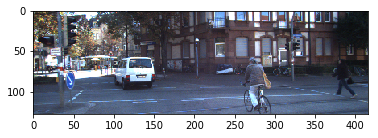

In [97]:
plt.imshow(im)

In [61]:
im = util.load_image(im_files[0], resize=(img_width, img_height))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [106]:
INPUT_DIR = '/Users/evinpinar/Documents/Classes/Seminar/2011_09_26/'

In [108]:
import os
import glob

glob.glob(INPUT_DIR)

['/Users/evinpinar/Documents/Classes/Seminar/2011_09_26/']

In [55]:
vars_to_restore = util.get_vars_to_save_and_restore(model_ckpt)
saver = tf.train.Saver(vars_to_restore)
sv = tf.train.Supervisor(logdir='/tmp/', saver=None)
with sv.managed_session() as sess:
    saver.restore(sess, model_ckpt)
    if not gfile.Exists(output_dir):
        gfile.MakeDirs(output_dir)
    logging.info('Predictions will be saved in %s.', output_dir)

    # Collect all images to run inference on.
    im_files, basepath_in = collect_input_images(input_dir, input_list_file,
                                                 file_extension)
    if shuffle:
        logging.info('Shuffling data...')
        np.random.shuffle(im_files)
    logging.info('Running inference on %d files.', len(im_files))

    # Create missing output folders and pre-compute target directories.
    output_dirs = create_output_dirs(im_files, basepath_in, output_dir)

RuntimeError: Graph is finalized and cannot be modified.

In [52]:


# Run depth prediction network.
if depth:
    im_batch = []
    for i in range(len(im_files)):
    if i % 100 == 0:
        logging.info('%s of %s files processed.', i, len(im_files))

    # Read image and run inference.
    if inference_mode == INFERENCE_MODE_SINGLE:
        if inference_crop == INFERENCE_CROP_NONE:
            im = util.load_image(im_files[i], resize=(img_width, img_height))
        elif inference_crop == INFERENCE_CROP_CITYSCAPES:
            im = util.crop_cityscapes(util.load_image(im_files[i]),
                                  resize=(img_width, img_height))
    elif inference_mode == INFERENCE_MODE_TRIPLETS:
        im = util.load_image(im_files[i], resize=(img_width * 3, img_height))
        im = im[:, img_width:img_width*2]
    if flip_for_depth:
      im = np.flip(im, axis=1)
    im_batch.append(im)

    if len(im_batch) == batch_size or i == len(im_files) - 1:
      # Call inference on batch.
        for _ in range(batch_size - len(im_batch)):  # Fill up batch.
            im_batch.append(np.zeros(shape=(img_height, img_width, 3),
                                 dtype=np.float32))
        im_batch = np.stack(im_batch, axis=0)
        est_depth = inference_model.inference_depth(im_batch, sess)
        if flip_for_depth:
            est_depth = np.flip(est_depth, axis=2)
            im_batch = np.flip(im_batch, axis=2)

      for j in range(len(im_batch)):
        color_map = util.normalize_depth_for_display(
            np.squeeze(est_depth[j]))
        visualization = np.concatenate((im_batch[j], color_map), axis=0)
        # Save raw prediction and color visualization. Extract filename
        # without extension from full path: e.g. path/to/input_dir/folder1/
        # file1.png -> file1
        k = i - len(im_batch) + 1 + j
        filename_root = os.path.splitext(os.path.basename(im_files[k]))[0]
        pref = '_flip' if flip_for_depth else ''
        output_raw = os.path.join(
            output_dirs[k], filename_root + pref + '.npy')
        output_vis = os.path.join(
            output_dirs[k], filename_root + pref + '.png')
        with gfile.Open(output_raw, 'wb') as f:
          np.save(f, est_depth[j])
        util.save_image(output_vis, visualization, file_extension)
      im_batch = []

# Run egomotion network.
if egomotion:
  if inference_mode == INFERENCE_MODE_SINGLE:
    # Run regular egomotion inference loop.
    input_image_seq = []
    input_seg_seq = []
    current_sequence_dir = None
    current_output_handle = None
    for i in range(len(im_files)):
      sequence_dir = os.path.dirname(im_files[i])
      if sequence_dir != current_sequence_dir:
        # Assume start of a new sequence, since this image lies in a
        # different directory than the previous ones.
        # Clear egomotion input buffer.
        output_filepath = os.path.join(output_dirs[i], 'egomotion.txt')
        if current_output_handle is not None:
          current_output_handle.close()
        current_sequence_dir = sequence_dir
        logging.info('Writing egomotion sequence to %s.', output_filepath)
        current_output_handle = gfile.Open(output_filepath, 'w')
        input_image_seq = []
      im = util.load_image(im_files[i], resize=(img_width, img_height))
      input_image_seq.append(im)
      if use_masks:
        im_seg_path = im_files[i].replace('.%s' % file_extension,
                                          '-seg.%s' % file_extension)
        if not gfile.Exists(im_seg_path):
          raise ValueError('No segmentation mask %s has been found for '
                           'image %s. If none are available, disable '
                           'use_masks.' % (im_seg_path, im_files[i]))
        input_seg_seq.append(util.load_image(im_seg_path,
                                             resize=(img_width, img_height),
                                             interpolation='nn'))

      if len(input_image_seq) < seq_length:  # Buffer not filled yet.
        continue
      if len(input_image_seq) > seq_length:  # Remove oldest entry.
        del input_image_seq[0]
        if use_masks:
          del input_seg_seq[0]

      input_image_stack = np.concatenate(input_image_seq, axis=2)
      input_image_stack = np.expand_dims(input_image_stack, axis=0)
      if use_masks:
        input_image_stack = mask_image_stack(input_image_stack,
                                             input_seg_seq)
      est_egomotion = np.squeeze(inference_model.inference_egomotion(
          input_image_stack, sess))
      egomotion_str = []
      for j in range(seq_length - 1):
        egomotion_str.append(','.join([str(d) for d in est_egomotion[j]]))
      current_output_handle.write(
          str(i) + ' ' + ' '.join(egomotion_str) + '\n')
    if current_output_handle is not None:
      current_output_handle.close()
  elif inference_mode == INFERENCE_MODE_TRIPLETS:
    written_before = []
    for i in range(len(im_files)):
      im = util.load_image(im_files[i], resize=(img_width * 3, img_height))
      input_image_stack = np.concatenate(
          [im[:, :img_width], im[:, img_width:img_width*2],
           im[:, img_width*2:]], axis=2)
      input_image_stack = np.expand_dims(input_image_stack, axis=0)
      if use_masks:
        im_seg_path = im_files[i].replace('.%s' % file_extension,
                                          '-seg.%s' % file_extension)
        if not gfile.Exists(im_seg_path):
          raise ValueError('No segmentation mask %s has been found for '
                           'image %s. If none are available, disable '
                           'use_masks.' % (im_seg_path, im_files[i]))
        seg = util.load_image(im_seg_path,
                              resize=(img_width * 3, img_height),
                              interpolation='nn')
        input_seg_seq = [seg[:, :img_width], seg[:, img_width:img_width*2],
                         seg[:, img_width*2:]]
        input_image_stack = mask_image_stack(input_image_stack,
                                             input_seg_seq)
      est_egomotion = inference_model.inference_egomotion(
          input_image_stack, sess)
      est_egomotion = np.squeeze(est_egomotion)
      egomotion_1_2 = ','.join([str(d) for d in est_egomotion[0]])
      egomotion_2_3 = ','.join([str(d) for d in est_egomotion[1]])

      output_filepath = os.path.join(output_dirs[i], 'egomotion.txt')
      file_mode = 'w' if output_filepath not in written_before else 'a'
      with gfile.Open(output_filepath, file_mode) as current_output_handle:
        current_output_handle.write(str(i) + ' ' + egomotion_1_2 + ' ' +
                                    egomotion_2_3 + '\n')
      written_before.append(output_filepath)
  logging.info('Done.')

IndentationError: expected an indented block (<ipython-input-52-b7de5ab2c503>, line 5)